## Setup

In [0]:
!pip uninstall tensorflow -yq
!pip install tensorflow-gpu>=2.0 gpustat matplotlib tqdm -Uq
!gpustat

f384af44ec19             Sun Dec 29 17:13:49 2019  418.67
[0] Tesla P100-PCIE-16GB | 37'C,   0 % |     0 / 16280 MB |


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import tensorflow.keras.layers as layers
print("Tensorflow Version:", tf.__version__)

assert tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Tensorflow Version: 2.0.0


In [0]:
from tensorflow.keras import initializers

mapping = {
    "GlorotNormal": initializers.GlorotNormal,
    "GlorotUniform": initializers.GlorotUniform,
    "Ones": initializers.Ones,
    "Zeros": initializers.Zeros,
    "RandomNormal": initializers.RandomNormal,
    "RandomUniform": initializers.RandomUniform,
    "he_normal": initializers.he_normal,
    "he_uniform": initializers.he_uniform
}

def get_init_function(init_name):
    return mapping[init_name]

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train/127.5)-1
x_test = (x_test/127.5)-1

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [0]:
def get_model(k_init, batch_norm, optimizer):
    _k_init = get_init_function(k_init)
    if batch_norm:
        l_batch_norm_1 = layers.BatchNormalization(fused=True)
        l_batch_norm_2 = layers.BatchNormalization(fused=True)
    else:
        l_batch_norm_1 = layers.Lambda(lambda x: x)
        l_batch_norm_2 = layers.Lambda(lambda x: x)
    model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu", input_shape=x_train.shape[1:]),
        layers.Conv2D(32, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Conv2D(32, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Conv2D(32, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Dropout(rate=0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        l_batch_norm_1,
        layers.Conv2D(64, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Conv2D(64, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Conv2D(64, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Conv2D(64, (3, 3), kernel_initializer=_k_init, padding='same', activation="relu"),
        layers.Dropout(rate=0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        l_batch_norm_2,
        layers.Flatten(),
        layers.Dense(128, kernel_initializer=_k_init, activation="relu"),
        layers.Dropout(rate=0.1),
        layers.Dense(10, kernel_initializer=_k_init),
        layers.Activation("softmax", dtype=tf.float32)
    ])
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

# Investigating DNN Training

In this notebook, we look at how **batch normalization** and **adaptive optimizers** (such as Adam) can help us train deeper models without careful reliance on the correct weight initialization scheme. This is increasingly important as models get wider (more parameters) and deeper (more layers).

**Without BatchNorm -> With BatchNorm -> With BatchNorm + Adam**

* `GlorotNormal`: 40% -> 67% -> 84%
* `GlorotUniform`: 40% -> 66% -> 85%
* `Ones`: 10% -> 10% -> 10%
* `Zeros`: 10% -> 10% -> 10%
* `RandomNormal`: 33% -> 59% -> 83%
* `RandomUniform`: 11% -> 60% -> 86%

Train on 50000 samples
Epoch 1/6
50000/50000 - 6s - loss: 1.4455 - accuracy: 0.4836
Epoch 2/6
50000/50000 - 5s - loss: 0.9729 - accuracy: 0.6548
Epoch 3/6
50000/50000 - 5s - loss: 0.7677 - accuracy: 0.7297
Epoch 4/6
50000/50000 - 5s - loss: 0.6252 - accuracy: 0.7782
Epoch 5/6
50000/50000 - 5s - loss: 0.5226 - accuracy: 0.8152
Epoch 6/6
50000/50000 - 5s - loss: 0.4336 - accuracy: 0.8465


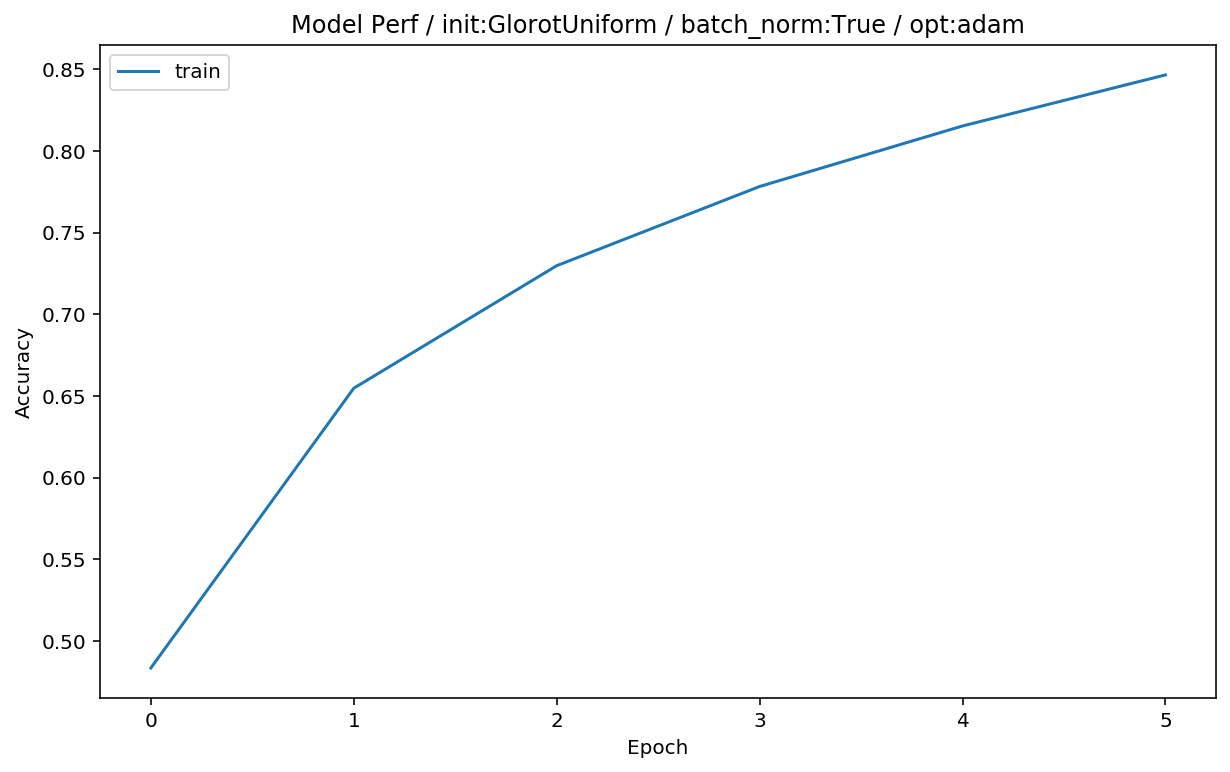

In [0]:
#@title Options { run: "auto" }

k_init = "GlorotUniform" #@param ["GlorotNormal", "GlorotUniform", "Ones", "Zeros", "RandomNormal", "RandomUniform"]
batch_norm = True #@param ["True", "False"] {type:"raw"}
optimizer = "adam" #@param ["adam", "sgd", "rmsprop", "adadelta"]

model = get_model(k_init, batch_norm, optimizer)
history = model.fit(x_train, y_train,
                    verbose=2, batch_size=256, epochs=6)

fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
title = " / ".join([
    "Model Perf", "init:"+k_init, "batch_norm:"+str(batch_norm), "opt:"+optimizer])
plt.title(title)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()